In [1]:

import brainpy.math as bm
import numpy as np
from PCCAN_utils import get_tuningMap, animate_sweeps
from models import PC_cell

#for generting behavioral trajectory
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent

#for plotting
import matplotlib.pyplot as plt
#grid spec
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import seaborn as sns

import os
from scipy.signal import find_peaks
from scipy.stats import pearsonr

import sys
sys.path.append('/home/zilong/Desktop/HoneycombSweeps/CircularLinearReg')
from core import cl_corr


%matplotlib inline  
%load_ext autoreload 
%autoreload 2

## Section 1: generate behavioral running trajectories in open fields using RatInABox

/tmp/ipykernel_871602/467648828.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("cool")  # 'winter' transitions from green to blue


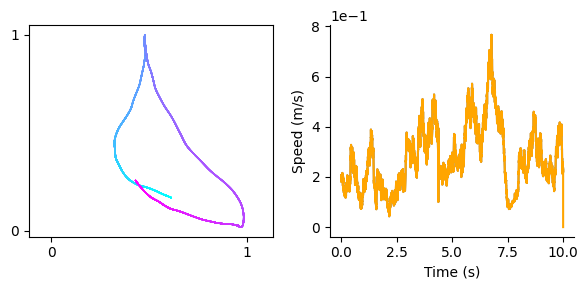

In [2]:
np.random.seed(111)

Env = Environment(params={
    'scale':1,
    "dimensionality": "2D",
})

dur = 10 #in seconds
dt = 0.001 #in seconds
speed_mean = 0.2 #in m/s
speed_std = 0.0 #in m/s
rotation_velocity_std = 60 * (np.pi / 180) #in rad/s

Ag = Agent(Env, params = {
    "dt": dt,
    "speed_mean":speed_mean,
    "speed_std": speed_std,
    "rotational_velocity_std": rotation_velocity_std, #set to 120 or 360 will change the tutoriocity of the trajectory
    })

while Ag.t < dur:
    Ag.update(drift_velocity=None)

Position = Ag.history['pos']
Position = np.array(Position)
# Position_2_2pi = Position*(2*np.pi)-np.pi
Vel = Ag.history['vel']
Speed = np.linalg.norm(Vel, axis=1) * dt # meters per ms

diff = np.diff(Position, axis=0)
Vel2 = np.zeros_like(Position)
Vel2[:-1,:] = diff
Speed2 = np.linalg.norm(Vel2, axis=1)

#visualize the trajectory
fig, axs = plt.subplots(1, 2, figsize=(6,3))
ax = axs[0]
# ax.plot(Position[:,1], Position[:,0], linewidth=0.5, color='black')
# ax.axis('equal')
# ax.set_xticks([])
# ax.set_yticks([])
# #invert_yaxis

# Set up a colour map from green to blue
cmap = cm.get_cmap("cool")  # 'winter' transitions from green to blue

# Plot each segment with a different colour
for i in range(len(Position) - 1):
    ax.plot(
        [Position[i, 0], Position[i + 1, 0]], 
        [Position[i, 1], Position[i + 1, 1]], 
        color=cmap(i / len(Position)), 
        linewidth=1
    )
ax.axis('equal')
ax.set_xticks([0,1])
ax.set_yticks([0,1])
# ax.invert_yaxis()

ax = axs[1]
ax.plot(np.arange(len(Speed))*dt, Speed/dt, label='speed', color='grey')
ax.plot(np.arange(len(Speed))*dt, Speed2/dt, label='speed2', color='orange')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_ylabel('Speed (m/s)')
ax.set_xlabel('Time (s)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

## Section 2: Simulate place cell network with homogeneous synaptic weights 

In [3]:
#set simulation parameters
bm.set_platform('gpu')
bm.set_dt(1.)

#hyperparameters
m0 = 15 #adaptation strength
z_min = 0; z_max = 1 #the size of the environment, have to be the same as the environment size
duration = int(dur/dt) #simulation duration of the trajectory
alpha_pc = 0.5 #theta modulation scale
v0 = 1/1000 #baseline speed per ms  
T_theta = 100 #ms, length of a theta cycle; frequency=10Hz
num = 50 #number of PC cells on x or y axis

bm.clear_buffer_memory(platform='gpu')

#build the network
PC_net = PC_cell(num=num, tau=10, tauv=100, m0=m0, k=1, a=0.08, A=10.0, J0=4.0, z_min=z_min, z_max=z_max)

def runNet(i, Animal_location, Speed):
    theta_mod_strength = alpha_pc * 1/v0 * Speed #faster run, higher theta modulation strength
    #calculate thetamodulator at time step i
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta
    ThetaModulator = 1+theta_mod_strength*bm.cos(theta_phase*2*bm.pi)
    
    #update place cell network using step_run
    PC_net.step_run(i, Animal_location, ThetaModulator)
    
    #get intermidiate results
    pc_activity = PC_net.r
    pc_bumcenter = PC_net.center
    return pc_activity, pc_bumcenter

time_steps = np.arange(len(Position))
print('Running simulation...')
pc_activity, pc_bumpcenter = bm.for_loop(runNet, (time_steps, Position, Speed))

#animate the sweeps and save the animation
print('Animating...')
save_path = './animations/'
filename_prefix = 'Plain_adaptation_'
animate_sweeps(Position, pc_activity, num, duration, Speed, m0, n_step=10, goal_loc=None, save_path=save_path, filename_prefix=filename_prefix)


2024-11-20 20:22:46.496316: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Running simulation...


MovieWriter imagemagick unavailable; using Pillow instead.


Animating...
Animation saved to ./animations/Plain_adaptation_15.gif


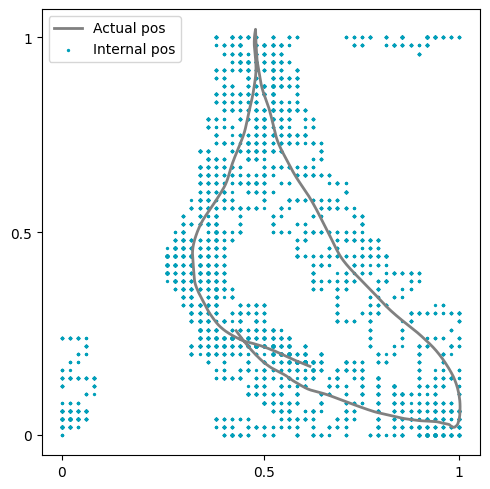

In [4]:
fig, ax  = plt.subplots(1, 1, figsize=(5,5), dpi=100)
# Static plot for position and bump center in the second subplot (axs[1])
ax.plot(Position[:, 0] * num, Position[:, 1] * num, color='grey', linewidth=2, label='Actual pos')
ax.scatter(pc_bumpcenter[:, 0], pc_bumpcenter[:, 1], color='#009FB9', s=2, label='Internal pos')

ax.set_xticks([0, num//2, num-1])
ax.set_xticklabels([0, 0.5, 1])
ax.set_yticks([0, num//2, num-1])
ax.set_yticklabels([0, 0.5, 1])
ax.legend()

plt.tight_layout()
plt.savefig('./figures/Plain_sweeptraj.pdf', dpi=300)

## Section 3: Simulate place cell network with inhomogeneous synaptic connection

In [3]:
#set simulation parameters
bm.set_platform('gpu')
bm.set_dt(1.0)

#hyperparameters
m0 = 15 #adaptation strength
z_min = 0; z_max = 1 #the size of the environment, have to be the same as the environment size
duration = int(dur/dt) #simulation duration of the trajectory
alpha_pc = 2.0 #theta modulation scale
v0 = 1/1000 #baseline speed per ms  
T_theta = 100 #ms, length of a theta cycle; frequency=10Hz
num = 50 #number of PC cells on x or y axis
goal_loc = [0.25, 0.25]

bm.clear_buffer_memory(platform='gpu')

#build the network
PC_net = PC_cell(num=num, tau=10, tauv=100, m0=m0, k=1, a=0.08, A=10.0, J0=4.0, z_min=z_min, z_max=z_max, 
                 goal_loc=goal_loc,
                 goal_J0=2.,
                 goal_a=0.3)

def runNet(i, Animal_location, Speed):
    theta_mod_strength = alpha_pc * 1/v0 * Speed #faster run, higher theta modulation strength
    #calculate thetamodulator at time step i
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta
    ThetaModulator = 1+theta_mod_strength*bm.cos(theta_phase*2*bm.pi)
    
    #update place cell network using step_run
    PC_net.step_run(i, Animal_location, ThetaModulator)
    
    #get intermidiate results
    pc_activity = PC_net.r
    pc_bumpcenter = PC_net.center
    return pc_activity, pc_bumpcenter, ThetaModulator

time_steps = np.arange(len(Position))
print('Running simulation...')
pc_activity, pc_bumpcenter, ThetaModulator= bm.for_loop(runNet, (time_steps, Position, Speed))

#animate the sweeps and save the animation
print('Animating...')
save_path = './animations/'
filename_prefix = 'Goal_adaptation_'
animate_sweeps(Position, pc_activity, num, duration, Speed, m0, z_max, n_step=10, goal_loc=goal_loc, save_path=save_path, filename_prefix=filename_prefix)

2024-12-11 20:44:00.662464: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Running simulation...


MovieWriter imagemagick unavailable; using Pillow instead.


Animating...
Animation saved to ./animations/Goal_adaptation_15.gif


In [1]:
fig, ax  = plt.subplots(1, 1, figsize=(5,5), dpi=100)
# Static plot for position and bump center in the second subplot (axs[1])
ax.plot(Position[:, 0] * num, Position[:, 1] * num, color='grey', linewidth=2, label='Actual pos')
ax.scatter(pc_bumpcenter[:, 0], pc_bumpcenter[:, 1], color='#009FB9', s=2, label='Internal pos')
ax.scatter(goal_loc[0]*num, goal_loc[1]*num, color='#009FB9', marker='*', s=200, label='Goal loc')

ax.set_xticks([0, num//2, num-1])
ax.set_xticklabels([0, 0.5, 1])
ax.set_yticks([0, num//2, num-1])
ax.set_yticklabels([0, 0.5, 1])
ax.legend()

plt.tight_layout()
plt.savefig('./figures/GD_sweeptraj.pdf', dpi=300)


NameError: name 'plt' is not defined

### 3.1. Producing paper figures: sweeps in several theta cycles

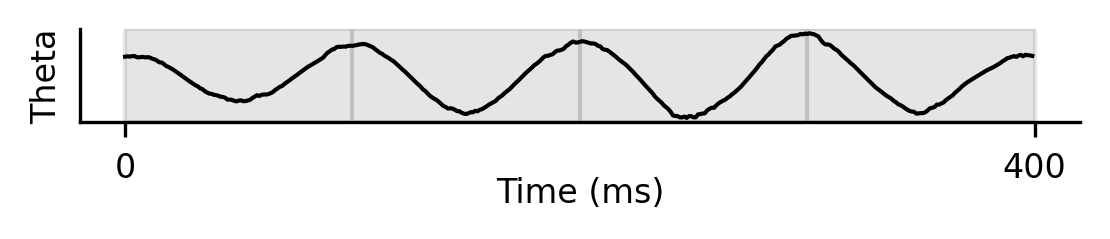

In [137]:
fig, ax = plt.subplots(1, 1, figsize=(3.8,0.9), dpi=300)

#plot ThetaModulator
start = 1100
end = 1500

ax.plot(ThetaModulator[1100:1500], color='black', linewidth=1)
#vertical area every 100 points
for i in range((end-start)//100):
    ax.axvspan(i*100, (i+1)*100, color='grey', alpha=0.2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0, end-start])
ax.set_yticks([])
ax.set_ylabel('Theta', fontsize=8)
ax.set_xlabel('Time (ms)', fontsize=8, labelpad=-2)
#ticksize to 8
ax.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()
plt.savefig('./figures/ThetaModulator.pdf', dpi=300)

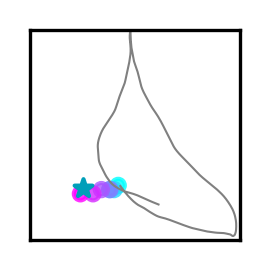

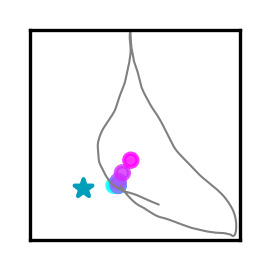

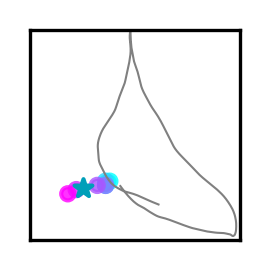

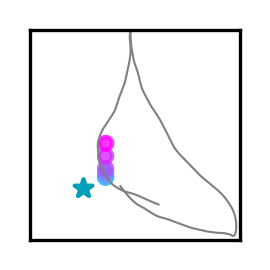

In [162]:


for i in range(4):

    start = 1100 + 100*i
    fig, ax = plt.subplots(1, 1, figsize=(1,1), dpi=300)

    cut = 70

    # Define the colormap and normalize it
    cmap = plt.cm.cool
    norm = plt.Normalize(vmin=start, vmax=start + cut)


    ax.plot(Position[:, 0] * num, Position[:, 1] * num, color='grey', linewidth=0.5, label='Actual pos')

    ax.scatter(
        pc_bumpcenter[start:start+cut, 0],
        pc_bumpcenter[start:start+cut, 1],
        c=np.linspace(start, start + cut, cut),  # Gradually changing values
        cmap=cmap,
        s=10,
        label='Internal pos',
        alpha = 0.8
    )

    ax.scatter(goal_loc[0]*num, goal_loc[1]*num, color='#009FB9', marker='*', s=20, label='Goal loc.')
    
    #add animals pos from start to start + cut
    # ax.scatter(Position[start:start+cut, 0]*num, Position[start:start+cut, 1]*num, color='#F18D00', marker = 'o', s=5, label='Actual pos')
    
    ax.set_xlim([0, num])
    ax.set_ylim([0, num])
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()
    plt.savefig(f'./figures/Goal_adaptation_{start}.pdf', dpi=300)


(-0.5, 49.5, -0.5, 49.5)

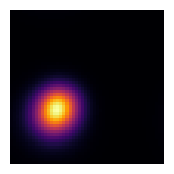

In [85]:
bump_in_a_cycle = pc_bumpcenter
fig, ax = plt.subplots(1, 1, figsize=(2,2), dpi=100)
ax.imshow(bump_in_a_cycle, aspect='equal', origin='lower', cmap='inferno')
ax.axis('off')

In [ ]:
bump_in_a_cycle = pc_activity[2180,:,:]
fig, ax = plt.subplots(1, 1, figsize=(2,2), dpi=100)
ax.imshow(bump_in_a_cycle, aspect='equal', origin='lower', cmap='inferno')
ax.axis('off')

### 3.2. Producing paper figures: connectivity matrix

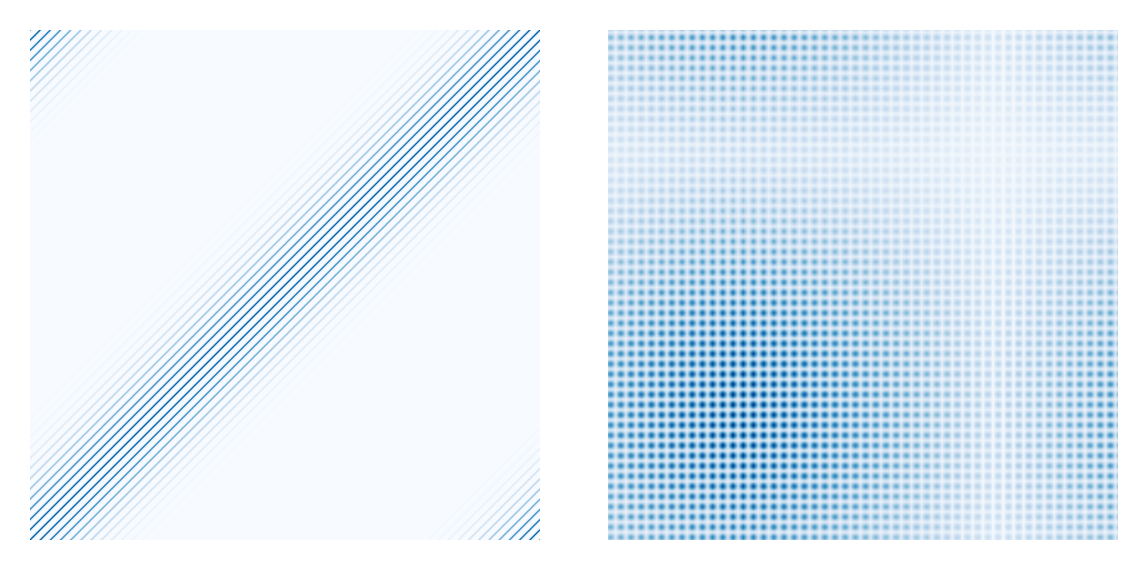

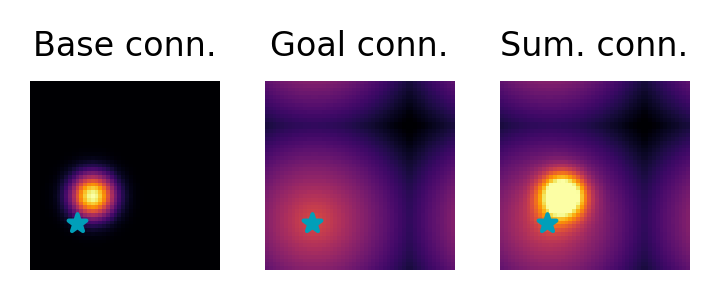

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(4,2), dpi=300)

ax = axs[0]
#show the baseline connection matrix and add colorbar
baseline_conn = PC_net.make_conn()
cax = ax.imshow(baseline_conn, cmap='Blues', aspect='equal', origin='lower')
# plt.colorbar(cax, ax=ax, shrink=0.7)
ax.axis('off')

ax = axs[1]
#show the goal connection matrix and add colorbar
gd_conn = PC_net.gd_conn
cax = ax.imshow(gd_conn, cmap='Blues', aspect='equal', origin='lower')
ax.axis('off')

plt.tight_layout()


#
fig, axs = plt.subplots(1, 3, figsize=(2.5,1), dpi=300)

ax = axs[0]
#show the baseline connection matrix and add colorbar
baseline_conn = PC_net.make_conn()
col_ind = 966

vmax = np.max(baseline_conn); vmin = np.min(baseline_conn)
cax = ax.imshow(baseline_conn[col_ind,:].reshape(num,num), cmap='inferno', aspect='equal', origin='lower', vmax=vmax, vmin=vmin)
# plt.colorbar(cax, ax=ax, shrink=0.7)
#add goal location into the plot

ax.scatter(int(goal_loc[0]*num), int(goal_loc[1]*num), color='#009FB9', marker='*', s=20)
ax.set_title('Base conn.', fontsize=8)
ax.axis('off')

ax = axs[1]
#show the goal connection matrix and add colorbar
gd_conn = PC_net.gd_conn
cax = ax.imshow(gd_conn[col_ind, :].reshape(num,num), cmap='inferno', aspect='equal', origin='lower', vmax=vmax/5, vmin=vmin/5)
ax.scatter(int(goal_loc[0]*num), int(goal_loc[1]*num), color='#009FB9', marker='*', s=20)
ax.set_title('Goal conn.', fontsize=8)
ax.axis('off')

ax = axs[2]
B_conn = baseline_conn[col_ind,:].reshape(num,num)
G_conn = gd_conn[col_ind,:].reshape(num,num)
#show the addition of the two connection matrices
cax = ax.imshow(B_conn+5*G_conn, cmap='inferno', aspect='equal', origin='lower', vmax=vmax, vmin=vmin)
ax.scatter(int(goal_loc[0]*num), int(goal_loc[1]*num), color='#009FB9', marker='*', s=20)
ax.set_title('Sum. conn.', fontsize=8)
ax.axis('off')

plt.tight_layout()

plt.savefig('./figures/conn_mat.pdf', dpi=300)

#### time consuming plot but looks nicer...

/home/zilong/anaconda3/envs/anticipative_track_gpu/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/zilong/anaconda3/envs/anticipative_track_gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


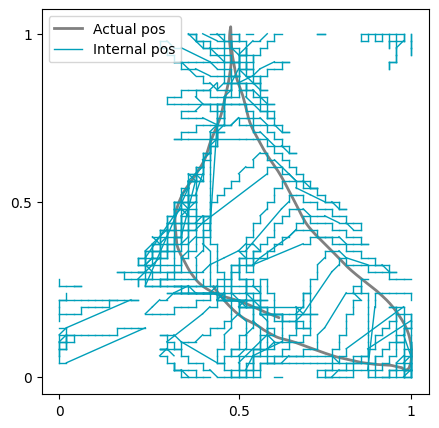

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)

# Plot the continuous trajectory for Position
ax.plot(Position[:, 0] * num, Position[:, 1] * num, color='grey', linewidth=2, label='Actual pos')

# Threshold for distance
threshold = 20

# Collect segments that meet the threshold condition
x_segments = []
y_segments = []
for i in range(len(pc_bumpcenter) - 1):
    # Calculate the Euclidean distance between consecutive points
    dist = np.sqrt((pc_bumpcenter[i+1, 0] - pc_bumpcenter[i, 0])**2 + (pc_bumpcenter[i+1, 1] - pc_bumpcenter[i, 1])**2)
    
    # If distance is below threshold, add segment to list
    if dist < threshold:
        x_segments.append([pc_bumpcenter[i, 0], pc_bumpcenter[i+1, 0]])
        y_segments.append([pc_bumpcenter[i, 1], pc_bumpcenter[i+1, 1]])

# Plot all segments at once
for x_seg, y_seg in zip(x_segments, y_segments):
    ax.plot(x_seg, y_seg, color='#009FB9', linewidth=1)

# Set fixed ticks and labels
ax.set_xticks([0, num//2, num-1])
ax.set_xticklabels([0, 0.5, 1])
ax.set_yticks([0, num//2, num-1])
ax.set_yticklabels([0, 0.5, 1])

# Add legend
ax.legend(['Actual pos', 'Internal pos'])


## Section 4: Simulate the network with a long trajectory and plot place fields of cells

[]

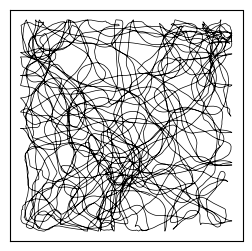

In [2]:
np.random.seed(111)

Env = Environment(params={
    'scale':1,
    "dimensionality": "2D",
})

dur = 400 #in seconds
dt = 0.001 #in seconds
speed_mean = 0.2 #in m/s
speed_std = 0.0 #in m/s
rotation_velocity_std = 180 * (np.pi / 180) #in rad/s

#if traj exist, load it, otherwise generate it
if os.path.exists('./traces/Traj_dur'+str(dur)+'_speedMean'+str(speed_mean)+'.npz'):
    data = np.load('./traces/Traj_dur'+str(dur)+'_speedMean'+str(speed_mean)+'.npz')
    Position = data['Position']-0.5
    Speed = data['Speed']
    Vel = data['Velocity']
else:
    Ag = Agent(Env, params = {
        "dt": dt,
        "speed_mean":speed_mean,
        "speed_std": speed_std,
        "rotational_velocity_std": rotation_velocity_std, #set to 120 or 360 will change the tutoriocity of the trajectory
        })

    while Ag.t < dur:
        Ag.update(drift_velocity=None)

    Position = Ag.history['pos']
    Position = np.array(Position)
    # Position_2_2pi = Position*(2*np.pi)-np.pi
    Vel = Ag.history['vel']
    Vel = np.array(Vel)
    Speed = np.linalg.norm(Vel, axis=1) * dt # meters per ms
    
    #calculate moving direction from Vel whihc is (x,y) at each time step
    moving_direction = np.zeros(len(Vel))
    for i in range(len(Vel)):
        moving_direction[i] = np.arctan2(Vel[i][1], Vel[i][0])
    
    np.savez('./traces/Traj_dur'+str(dur)+'_speedMean'+str(speed_mean)+'.npz', Position=Position, Speed=Speed, Velocity=Vel, Direction=moving_direction, dur=dur)

fig, ax = plt.subplots(1, 1, figsize=(3,3))

ax.plot(Position[:,0], Position[:,1], linewidth=0.5, color='black')
ax.axis('equal')
ax.set_xticks([])
ax.set_yticks([])


### Simulate the PC network with a long running trajectory

In [3]:
#set simulation parameters
bm.set_platform('gpu')
bm.set_dt(1.0) #ms
bm.clear_buffer_memory(platform='gpu')

#hyperparameters
m0 = 20 #adaptation strength
z_min = 0; z_max = 1 #the size of the environment, have to be the same as the environment size
duration = int(dur/dt) #simulation duration of the trajectory
alpha_pc = 2.0 #theta modulation scale
v0 = 1/1000 #baseline speed per ms  
T_theta = 100 #ms, length of a theta cycle; frequency=10Hz
num = 50 #number of PC cells on x or y axis
goal_loc = [0.25, 0.25]

#build the network
PC_net = PC_cell(num=num, tau=10, tauv=100, m0=m0, k=1, a=0.08, A=10.0, J0=4.0, z_min=z_min, z_max=z_max, 
                 goal_loc=goal_loc,
                 goal_J0=2.,
                 goal_a=0.4)

def runNet(i, Animal_location, Speed):
    theta_mod_strength = alpha_pc * 1/v0 * Speed #faster run, higher theta modulation strength
    #calculate thetamodulator at time step i
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta
    ThetaModulator = 1+theta_mod_strength*bm.cos(theta_phase*2*bm.pi)
    
    #update place cell network using step_run
    PC_net.step_run(i, Animal_location, ThetaModulator)
    
    #get intermidiate results
    pc_activity = PC_net.r
    pc_bumpcenter = PC_net.center
    return pc_activity, pc_bumpcenter, theta_phase, ThetaModulator

time_steps = np.arange(len(Position))
print('Running simulation...')

@bm.jit
def run(time, pos, seepd):
    return bm.for_loop(runNet, (time, pos, seepd))

# pc_activity, pc_bumpcenter, theta_phase, theta_rhythm= bm.for_loop(runNet, (time_steps, Position, Speed))
simulate_time = 50000  #every 50s perform the simulation, otherwise the gpu will run out of memory 

# Pre-allocate arrays
pc_activity = np.empty((len(Position), num, num))
pc_bumpcenter = np.empty((len(Position), 2))
theta_phase = np.empty(len(Position))
theta_rhythm = np.empty(len(Position))

for i in range(0, len(Position), simulate_time):
    print('Simulation progress: %.0f%%' % (i/len(Position)*100))
    pc_activity_i, pc_bumpcenter_i, theta_phase_i, theta_rhythm_i = run(time_steps[i:i+simulate_time], Position[i:i+simulate_time], Speed[i:i+simulate_time])
    #send data to cpu and store them
    pc_activity[i:i+simulate_time,:,:] = np.asarray(pc_activity_i)
    pc_bumpcenter[i:i+simulate_time,:] = np.asarray(pc_bumpcenter_i)
    theta_phase[i:i+simulate_time] = np.asarray(theta_phase_i)
    theta_rhythm[i:i+simulate_time] = np.asarray(theta_rhythm_i)

2024-12-11 14:52:47.923418: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Running simulation...
Simulation progress: 0%
Simulation progress: 12%
Simulation progress: 25%
Simulation progress: 37%
Simulation progress: 50%
Simulation progress: 62%
Simulation progress: 75%
Simulation progress: 87%
Simulation progress: 100%


### show running trajectory, firing rate map of a cell and the mean map

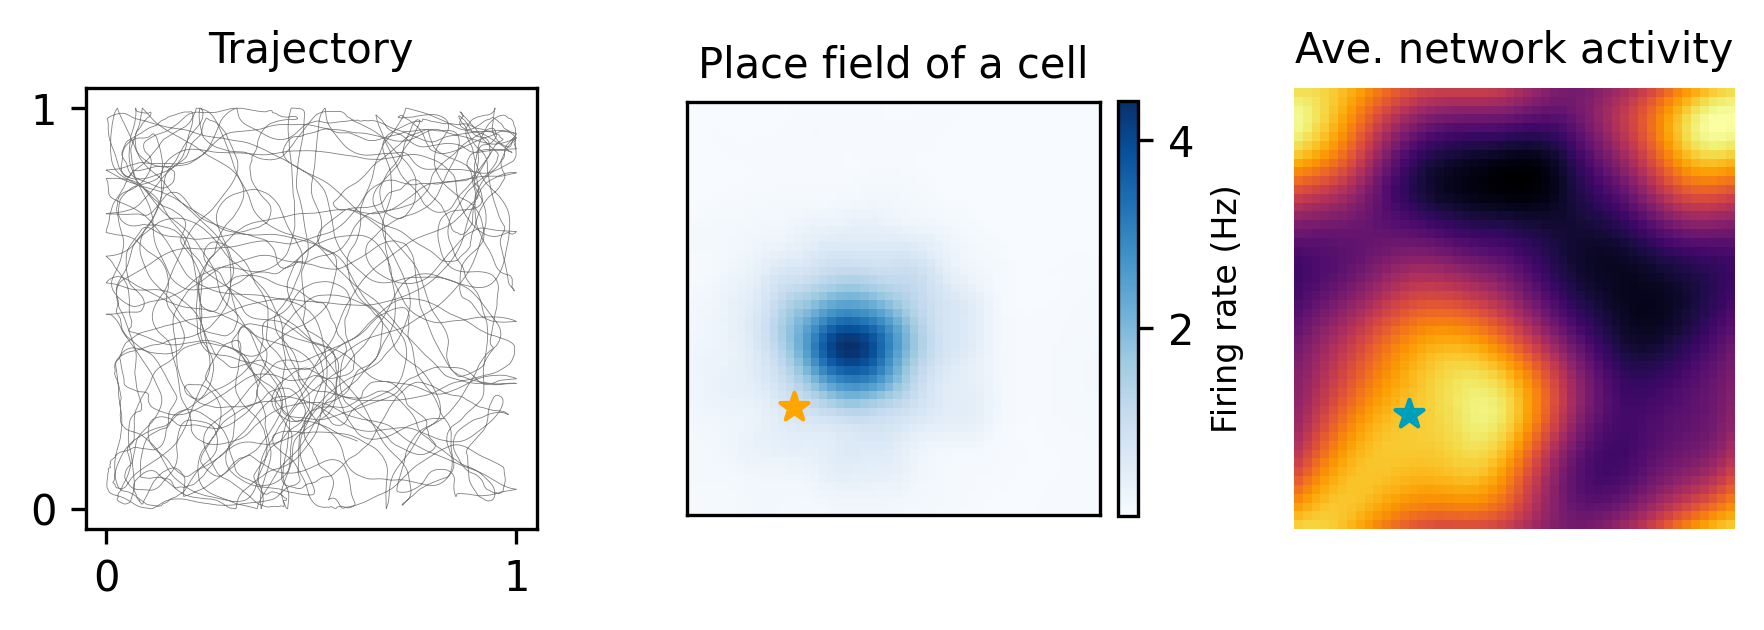

In [4]:
#plot all the firing rates in a single merged image
fig, axs = plt.subplots(1,3, figsize=(6,2.2), dpi=300)

ind=1500

#plot the trajectory
axs[0].plot(Position[:,0], Position[:,1], color='black', linewidth=0.2, alpha=0.5)
axs[0].set_xticks([0,1])
axs[0].set_yticks([0,1])
axs[0].set_xlim(0, 1)  # Restrict x-axis from 0 to 1
axs[0].set_ylim(0, 1)  # Restrict y-axis from 0 to 1
axs[0].set_title('Trajectory', fontsize=10)
axs[0].axis('auto')

cellindex = [20,20]
map = get_tuningMap(pc_activity, 
                    Position, 
                    cellindex_x=cellindex[0],
                    cellindex_y=cellindex[1],
                    shift = 0,
                    filter= True,
                    samples_per_sec=1000,
                    dim=num)

axs[1].imshow(map, cmap='Blues', origin='lower')
#add goal_loc 
axs[1].scatter(goal_loc[0]*num, goal_loc[1]*num, color='orange', marker='*', s=50)

axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('Place field of a cell', fontsize=10)
cbar = plt.colorbar(axs[1].imshow(map, cmap='Blues', origin='lower'), ax=axs[1], orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Firing rate (Hz)', fontsize=8)

axs[2].imshow(pc_activity.mean(axis=0), cmap='inferno', origin='lower')
#add goal location
axs[2].scatter(goal_loc[0]*num, goal_loc[1]*num, color='#009FB9', marker='*', s=50)
axs[2].axis('off')
axs[2].set_title('Ave. network activity', fontsize=10)

plt.tight_layout()

plt.savefig('./figures/placefield.pdf', dpi=300)

### 4.1. Producing paper figures: trajectory, place fields of several cells and the mean map

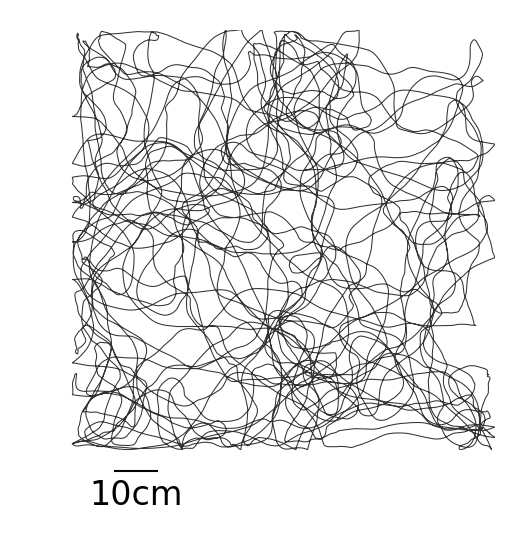

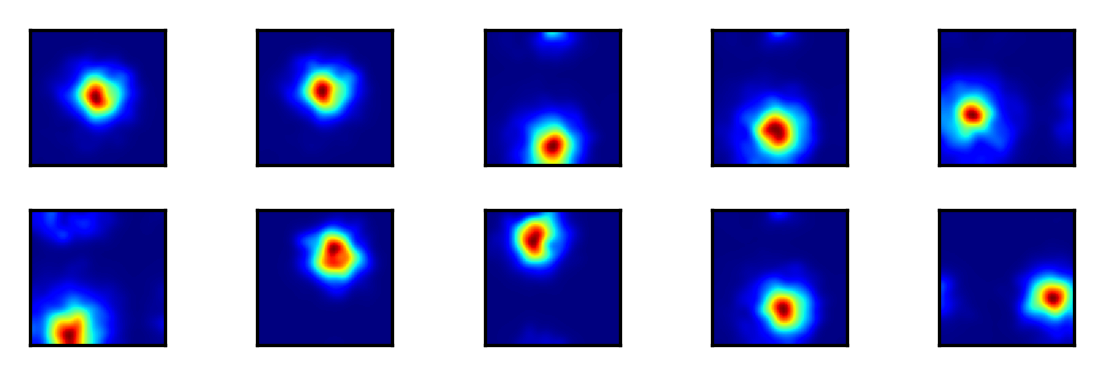

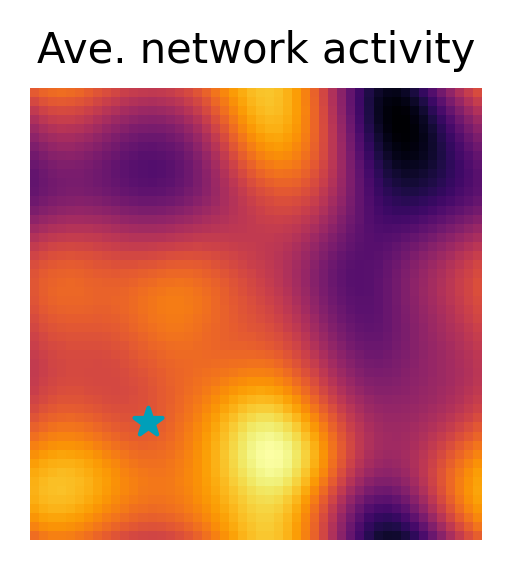

In [6]:
#plot all the firing rates in a single merged image
fig, ax = plt.subplots(1,1, figsize=(2,2), dpi=300)

#plot the trajectory
ax.plot(Position[:,0], Position[:,1], color='black', linewidth=0.25, alpha=0.8)
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xlim(-0.1, 1)  # Restrict x-axis from 0 to 1
ax.set_ylim(-0.1, 1)  # Restrict y-axis from 0 to 1
# ax.set_title('Trajectory', fontsize=10)
ax.axis('off')


# Add a scale bar
bar_length = 0.1
bar_x_start = 0.1  # Adjust as needed
bar_y = -0.05  # Position above the bottom
ax.plot([bar_x_start, bar_x_start + bar_length], [bar_y, bar_y], color='black', linewidth=0.5)

# Optionally, label the scale bar
ax.text(bar_x_start + bar_length / 2, bar_y - 0.02, f'{int(bar_length*100)}cm', 
        ha='center', va='top', fontsize=8)

plt.savefig('./figures/trajectory.pdf', dpi=300)


#plot all the firing rates in a single merged image
fig, axs = plt.subplots(2,5, figsize=(4,1.35), dpi=300)

for i in range(10):
    cellindex_x = np.random.randint(5, num-5)
    cellindex_y = np.random.randint(5, num-5)
    map = get_tuningMap(pc_activity, 
                        Position, 
                        cellindex_x=cellindex_x,
                        cellindex_y=cellindex_y,
                        shift = 0,
                        filter= True,
                        samples_per_sec=1000,
                        dim=num)
    
    ax = axs[i//5, i%5]

    ax.imshow(map, cmap='Blues', origin='lower')
    #add goal_loc 
    # ax.scatter(goal_loc[0]*num, goal_loc[1]*num, color='orange', marker='*', s=50)

    ax.set_xticks([])
    ax.set_yticks([])
    # ax.set_title('Place field of a cell', fontsize=10)
    ax.imshow(map, cmap='jet', origin='lower')
    # cbar.set_label('Firing rate (Hz)', fontsize=8)

plt.tight_layout()
plt.savefig('./figures/placefield_sample.pdf', dpi=300)

#plot the average network activity
fig, ax = plt.subplots(1,1, figsize=(2,2), dpi=300)

ax.imshow(pc_activity.mean(axis=0), cmap='inferno', origin='lower')
#add goal location
ax.scatter(goal_loc[0]*num, goal_loc[1]*num, color='#009FB9', marker='*', s=50)
ax.axis('off')
ax.set_title('Ave. network activity', fontsize=10)

plt.tight_layout()

plt.savefig('./figures/network_activity.pdf', dpi=300)


### get sweep direction relative to the goal direction

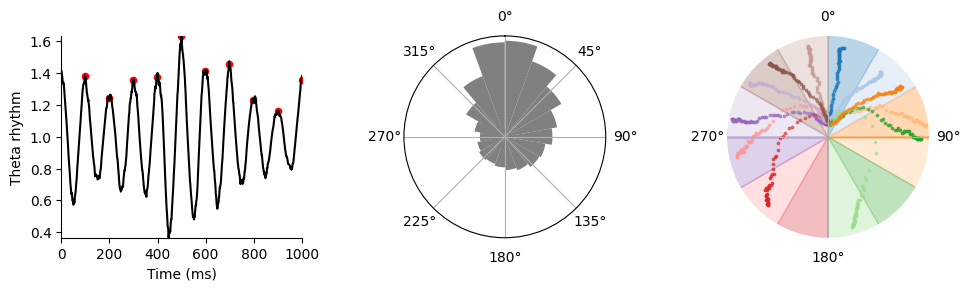

In [5]:
#find peak using scipy.signal.find_peaks
peaks, _ = find_peaks(theta_phase)

#plot theta_rhythm and mark peaks as red dots
# fig, axs = plt.subplots(1, 3, figsize=(10, 3), dpi=100)
#gridspec
fig = plt.figure(figsize=(10, 3), dpi=100)
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])

ax = plt.subplot(gs[0])
ax.plot(theta_rhythm, color='black')
ax.scatter(peaks, theta_rhythm[peaks], color='red', s=20)
ax.set_xlim(0, 1000)
ax.set_ylim(np.min(theta_rhythm[:1000]), np.max(theta_rhythm[:1000]))
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Theta rhythm')
sns.despine()

Angle_at_zeroPhase = []
BumpAngle_2_goal = [] #same dime as Angle_at_zeroPhase
BumpAngle_at_all_phase = []
BumpDist_2_pos = []

#at each peak, calculate the angle between moving direction and the vector from the Position to the goal location
for i in range(len(peaks)-1):
    #calculate the vector from the Position to the goal location
    vec = np.array([goal_loc[0] - Position[peaks[i], 0], goal_loc[1] - Position[peaks[i], 1]])
    #calculate the angle between from vector to the moving direction
    angle = np.arctan2(vec[1], vec[0]) - np.arctan2(Vel[peaks[i], 1], Vel[peaks[i], 0])
    angle = np.degrees(angle) % 360
    Angle_at_zeroPhase.append(angle)
    
    bumpTraj_in_Acycle = pc_bumpcenter[peaks[i]:peaks[i+1], :]/num
    BumpAngle = []
    BumpDist = []
    for j in range(len(bumpTraj_in_Acycle)):
        #calculate the angle between sweeps and Position at the peak (zero phase)
        vec2 = np.array([bumpTraj_in_Acycle[j, 0] - Position[peaks[i], 0], bumpTraj_in_Acycle[j, 1] - Position[peaks[i], 1]])
        # Calculate sweep angle relative to goal
        angle2 = np.arctan2(vec2[1], vec2[0]) - np.arctan2(vec[1], vec[0])
        angel2 = np.degrees(angle2) % 360
        BumpAngle_2_goal.append(angle2)
        
        #calculate the angle between sweeps and moving direction
        angle3 = np.arctan2(vec2[1], vec2[0]) - np.arctan2(Vel[peaks[i], 1], Vel[peaks[i], 0])
        angle3 = np.degrees(angle3) % 360
        BumpAngle.append(angle3)
        
        #calculate bump distance to the position
        dist = np.linalg.norm(vec2)
        dist = np.where(dist > 0.5, 1.0 - dist, dist)
        BumpDist.append(dist)
    BumpAngle_at_all_phase.append(BumpAngle)
    BumpDist_2_pos.append(BumpDist)

ax = plt.subplot(gs[1], projection='polar') 
ax.hist(BumpAngle_2_goal, bins=36, color='grey')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_yticks([])

####################################################################################################

ax = plt.subplot(gs[2], projection='polar')
ax.set_yticks([])
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_ylim(0, 0.2)
ax.spines['polar'].set_visible(False)
#plasce 0 at the top
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
#initialize 12 colors from tab20
colors = sns.color_palette("tab20", 12)
#color 1 to 12 rerpesent degree range of 0-30, 30-60, etc

# Shade each sector of the polar plot with the respective color
for i in range(360 // 30):
    ax.fill_between([np.radians(i * 30), np.radians((i + 1) * 30)], 0, 1, color=colors[i], alpha=0.3)

scatter_angles = []
scatter_distances = []
scatter_colors = []
scatter_alphas = []

sweep_info = {}

#clasifiy sweeps into 12 bins with 30 degree each
for goal_ang, sweep_angs, sweep_dist in zip(Angle_at_zeroPhase, BumpAngle_at_all_phase, BumpDist_2_pos):
    goal_ang = goal_ang % 360
    indx = int(goal_ang // 30)
    #append sweep_angs and sweep_dist to a dictionary with indx as key
    if indx not in sweep_info:
        sweep_info[indx] = []
    sweep_info[indx].append((sweep_angs, sweep_dist))

#in each angular bin, calculate the mean sweep angle and distance
for key in sweep_info:
    sweep_info_key = sweep_info[key]
    SA = []
    SD = []
    for sweep_angs, sweep_dist in sweep_info_key:
        SA.append(sweep_angs[0:80])
        SD.append(sweep_dist[0:80])
    #to numpy array using stack
    SA = np.stack(SA)
    SD = np.stack(SD)
    
    # Convert angles in SA to complex numbers
    complex_angles = np.exp(1j * np.radians(SA))  # Convert angles to radians and then to complex form
    mean_complex = np.mean(complex_angles, axis=0)  # Calculate mean in complex plane
    SA_mean = np.degrees(np.angle(mean_complex)) % 360  # Convert back to degrees and wrap to 0-360
    
    # Calculate mean distance
    SD_mean = np.mean(SD, axis=0)
    
    # Store points for batch scatter plot
    for i, (ang, dist) in enumerate(zip(SA_mean, SD_mean)):
        scatter_angles.append(np.radians(ang))
        scatter_distances.append(dist)
        scatter_colors.append(colors[key])
        alpha = i/len(SA_mean)
        scatter_alphas.append(alpha)

#plot mean sweep agle and distance in each angular bin
for i in range(len(scatter_angles)):
    ax.scatter(scatter_angles[i], scatter_distances[i], color=scatter_colors[i], s=3, alpha=scatter_alphas[i])


plt.tight_layout()

In [ ]:
#find peak using scipy.signal.find_peaks
peaks, _ = find_peaks(theta_phase)

#plot theta_rhythm and mark peaks as red dots
# fig, axs = plt.subplots(1, 3, figsize=(10, 3), dpi=100)
#gridspec
fig = plt.figure(figsize=(4.0, 2), dpi=100)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

Angle_at_zeroPhase = []
BumpAngle_2_goal = [] #same dime as Angle_at_zeroPhase
BumpAngle_at_all_phase = []
BumpDist_2_pos = []

#at each peak, calculate the angle between moving direction and the vector from the Position to the goal location
for i in range(len(peaks)-1):
    #calculate the vector from the Position to the goal location
    vec = np.array([goal_loc[0] - Position[peaks[i], 0], goal_loc[1] - Position[peaks[i], 1]])
    #calculate the angle between from vector to the moving direction
    angle = np.arctan2(vec[1], vec[0]) - np.arctan2(Vel[peaks[i], 1], Vel[peaks[i], 0])
    angle = np.degrees(angle) % 360
    Angle_at_zeroPhase.append(angle)
    
    bumpTraj_in_Acycle = pc_bumpcenter[peaks[i]:peaks[i+1], :]/num
    BumpAngle = []
    BumpDist = []
    for j in range(len(bumpTraj_in_Acycle)):
        #calculate the angle between sweeps and Position at the peak (zero phase)
        vec2 = np.array([bumpTraj_in_Acycle[j, 0] - Position[peaks[i], 0], bumpTraj_in_Acycle[j, 1] - Position[peaks[i], 1]])
        # Calculate sweep angle relative to goal
        angle2 = np.arctan2(vec2[1], vec2[0]) - np.arctan2(vec[1], vec[0])
        angel2 = np.degrees(angle2) % 360
        BumpAngle_2_goal.append(angle2)
        
        #calculate the angle between sweeps and moving direction
        angle3 = np.arctan2(vec2[1], vec2[0]) - np.arctan2(Vel[peaks[i], 1], Vel[peaks[i], 0])
        angle3 = np.degrees(angle3) % 360
        BumpAngle.append(angle3)
        
        #calculate bump distance to the position
        dist = np.linalg.norm(vec2)
        dist = np.where(dist > 0.5, 1.0 - dist, dist)
        BumpDist.append(dist)
    BumpAngle_at_all_phase.append(BumpAngle)
    BumpDist_2_pos.append(BumpDist)

ax = plt.subplot(gs[0], projection='polar') 
ax.hist(BumpAngle_2_goal, bins=36, color='grey')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_yticks([])

#tickszie to 8
ax.tick_params(axis='both', which='major', labelsize=8)

####################################################################################################

ax = plt.subplot(gs[1], projection='polar')
ax.set_yticks([])
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_ylim(0, 0.2)
ax.spines['polar'].set_visible(False)
#plasce 0 at the top
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
#initialize 12 colors from tab20
colors = sns.color_palette("tab20", 12)
#color 1 to 12 rerpesent degree range of 0-30, 30-60, etc

# Shade each sector of the polar plot with the respective color
for i in range(360 // 30):
    ax.fill_between([np.radians(i * 30), np.radians((i + 1) * 30)], 0, 1, color=colors[i], alpha=0.3)

scatter_angles = []
scatter_distances = []
scatter_colors = []
scatter_alphas = []

sweep_info = {}

#clasifiy sweeps into 12 bins with 30 degree each
for goal_ang, sweep_angs, sweep_dist in zip(Angle_at_zeroPhase, BumpAngle_at_all_phase, BumpDist_2_pos):
    goal_ang = goal_ang % 360
    indx = int(goal_ang // 30)
    #append sweep_angs and sweep_dist to a dictionary with indx as key
    if indx not in sweep_info:
        sweep_info[indx] = []
    sweep_info[indx].append((sweep_angs, sweep_dist))

#in each angular bin, calculate the mean sweep angle and distance
for key in sweep_info:
    sweep_info_key = sweep_info[key]
    SA = []
    SD = []
    for sweep_angs, sweep_dist in sweep_info_key:
        SA.append(sweep_angs[20:80])
        SD.append(sweep_dist[20:80])
    #to numpy array using stack
    SA = np.stack(SA)
    SD = np.stack(SD)
    
    # Convert angles in SA to complex numbers
    complex_angles = np.exp(1j * np.radians(SA))  # Convert angles to radians and then to complex form
    mean_complex = np.mean(complex_angles, axis=0)  # Calculate mean in complex plane
    SA_mean = np.degrees(np.angle(mean_complex)) % 360  # Convert back to degrees and wrap to 0-360
    
    # Calculate mean distance
    SD_mean = np.mean(SD, axis=0)
    
    # Store points for batch scatter plot
    for i, (ang, dist) in enumerate(zip(SA_mean, SD_mean)):
        scatter_angles.append(np.radians(ang))
        scatter_distances.append(dist)
        scatter_colors.append(colors[key])
        alpha = i/len(SA_mean)
        scatter_alphas.append(alpha)

#plot mean sweep agle and distance in each angular bin
for i in range(len(scatter_angles)):
    ax.scatter(scatter_angles[i], scatter_distances[i], color=scatter_colors[i], s=3, alpha=scatter_alphas[i])

#ticksize to 8
ax.tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()

plt.savefig('./figures/GDSweeps.pdf', dpi=300)

### check if sweep length depending on the distance to goal location

Pearson correlation coefficient: 0.360, p-value: 0.000


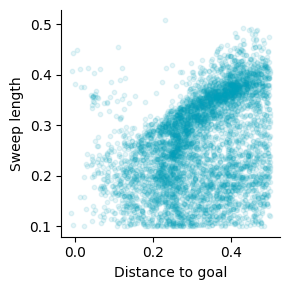

In [6]:
peaks, _ = find_peaks(theta_phase)


Dist2goal = []
SweepLength = []
#at each peak, calculate the angle between moving direction and the vector from the Position to the goal location
for i in range(len(peaks)-1):
    #calculate the vector from the Position to the goal location
    vec = np.array([goal_loc[0]- Position[peaks[i], 0], goal_loc[1] - Position[peaks[i], 1]])
    #get the distance
    dist = np.linalg.norm(vec)
    dist = np.where(dist > 0.5, 1.0 - dist, dist)
    
    bumpTraj_in_Acycle = pc_bumpcenter[peaks[i]:peaks[i+1], :]/num
    sweepdist2position = []
    for j in range(len(bumpTraj_in_Acycle)):
        #calculate the angle between sweeps and Position at the peak (zero phase)
        vec2 = np.array([bumpTraj_in_Acycle[j, 0] - Position[peaks[i], 0], bumpTraj_in_Acycle[j, 1] - Position[peaks[i], 1]])
        #get the distance
        dist2 = np.linalg.norm(vec2)
        dist2 = np.where(dist2 > 0.5, 1.0 - dist2, dist2)
        sweepdist2position.append(dist2)
    sweep_length = np.max(sweepdist2position) - np.min(sweepdist2position)
    if sweep_length < 0.1:
        continue
    Dist2goal.append(dist)
    SweepLength.append(sweep_length)

#plot SweepLength against Dist2goal
fig, ax = plt.subplots(1, 1, figsize=(3,3), dpi=100)
ax.scatter(Dist2goal, SweepLength, color='#009FB9', s=10, alpha=0.1)
ax.set_xlabel('Distance to goal')
ax.set_ylabel('Sweep length')
sns.despine()
plt.tight_layout()

#peasrson correlation
r, p = pearsonr(Dist2goal, SweepLength)
print('Pearson correlation coefficient: %.3f, p-value: %.3f' % (r, p))
    

## Check spike phase against distance to goal, as well as ConSink cells

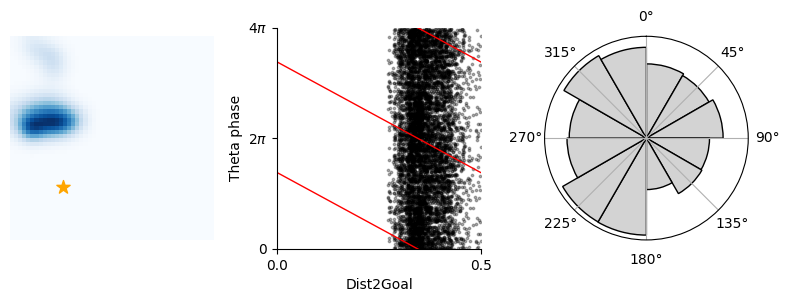

In [10]:
#Vel, Position, goal_loc, pc_activity
pc_activity.shape

# variable needed: cellindex, pc_activity, Position, goal_loc, theta_phase

addfitline = True

fig = plt.figure(figsize=(8,3), dpi=100)
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])

cellindex = [10, 20]

ax = plt.subplot(gs[0])
#tuning map of a cell

tuningMap = get_tuningMap(pc_activity, 
                          Position, 
                          cellindex_x=cellindex[0],
                          cellindex_y=cellindex[1],
                          shift = 0,
                          filter=True,
                          samples_per_sec=1000,
                          dim=num)
ax.imshow(tuningMap, cmap='Blues', origin='lower')

#mark the goal location
ax.scatter(goal_loc[0]*num, goal_loc[1]*num, color='Orange', marker='*', s=100)

ax.axis('off')


####################################################################################################

#Phase against distance to goal

ax = plt.subplot(gs[1])
Dist2G = []
SpikePhase = []
RelativeDirection = []

r = pc_activity[:, cellindex[0], cellindex[1]] * 1000 #ms to s

for i in range(len(Position)):
    #get the distance to goal_loc
    dist_i = np.linalg.norm(Position[i] - goal_loc)
    dist_i = np.where(dist_i > 0.5, 1.0 - dist_i, dist_i)
    
    #get the vec pointing from Position to goal_loc
    vec = goal_loc - Position[i]
    #get the angle between vec and moving direction
    angle = np.arctan2(vec[1], vec[0]) - np.arctan2(Vel[i, 1], Vel[i, 0])
    angle = np.degrees(angle) % 360
    
    #get the phase at current time step i
    phase_i = theta_phase[i]*np.pi*2
    
    spikes = np.random.poisson(r[i]*dt*10)
    if spikes > 0:
        #save dist_i and phase_i
        Dist2G.append(dist_i)
        SpikePhase.append(phase_i)
        RelativeDirection.append(angle)

Dist2G = np.asarray(Dist2G)
SpikePhase = np.asarray(SpikePhase)

ax.scatter(Dist2G, SpikePhase, s=3, color='black', alpha=0.3)

ax.scatter(Dist2G, SpikePhase+2*np.pi, s=3, color='black', alpha=0.3)

circ_lin_corr, pval, slope, phi0, RR = cl_corr(Dist2G, SpikePhase, min_slope=-2, max_slope=2, bootstrap_iter=3000, return_pval=True)

if addfitline:
    # Plot the circular-linear regression
    x = np.linspace(-np.pi, np.pi, 100)
    y = 2 * np.pi * slope * x + phi0
    ax.plot(x, y, color='red', linewidth=1)
    #add intercepr of 2*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 + 2 * np.pi
    ax.plot(x, y, color='red', linewidth=1)
    #add intercepr of 4*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 + 4 * np.pi
    ax.plot(x, y, color='red', linewidth=1)
    #substrac intercepr of 2*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 - 2 * np.pi
    ax.plot(x, y, color='red', linewidth=1)  

# ax[0].set_xlabel('Head direction')
ax.set_xlabel('Dist2Goal', fontsize=10)
ax.set_ylabel('Theta phase', fontsize=10)
#activity colorbar
ax.set_xlim(0, 0.5)
ax.set_xticks([0, 0.5])
ax.set_ylim(0, 4*np.pi)
ax.set_yticks([0, 2*np.pi, 4*np.pi])
ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])   

sns.despine()

####################################################################################################
#ConSink
ax = plt.subplot(gs[2], projection='polar')
#plot RelativeDirection histogram as a polar plot, with edgecolor as black, facecolor as None
ax.hist(np.radians(RelativeDirection), bins=12, color='lightgrey', edgecolor='black')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_yticks([])
plt.tight_layout()


### plot spike phase against distance to goal for all cells

In [8]:
# variable needed: cellindex, pc_activity, Position, goal_loc, theta_phase

#for cell index x vary from 0-49 and y vary from 0-49, plot the tuning map and the phase of spikes at each time step

all_clcc = []

for xi in range(0, num, 5):
    for yi in range(0, num, 5):
        print('Processing cell index: ', xi, yi)
        cellindex = [xi, yi]

        fig = plt.figure(figsize=(8,3), dpi=100)
        gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])
        
        ####################################################################################################
        ax = plt.subplot(gs[0])
        #plot the tuning map
        tuningMap = get_tuningMap(pc_activity, 
                                    Position, 
                                    cellindex_x=cellindex[0],
                                    cellindex_y=cellindex[1],
                                    shift = 0,
                                    filter=True,
                                    samples_per_sec=1000,
                                    dim=num)
        ax.imshow(tuningMap, cmap='Blues', origin='lower')

        #mark the goal location
        ax.scatter(goal_loc[0]*num, goal_loc[1]*num, color='Orange', marker='*', s=100)

        ax.axis('off')


        ####################################################################################################
        #Phase against distance to goal
        ax = plt.subplot(gs[1])
        
        Dist2G = []
        SpikePhase = []
        RelativeDirection = []

        r = pc_activity[:, cellindex[0], cellindex[1]] * 1000 #ms to s

        for i in range(len(Position)):
            #get the distance to goal_loc
            dist_i = np.linalg.norm(Position[i] - goal_loc)
            dist_i = np.where(dist_i > 0.5, 1.0 - dist_i, dist_i)
  
            #get the vec pointing from Position to goal_loc
            vec = goal_loc - Position[i]
            #get the angle between vec and moving direction
            angle = np.arctan2(vec[1], vec[0]) - np.arctan2(Vel[i, 1], Vel[i, 0])
            angle = np.degrees(angle) % 360
            
            #get the phase at current time step i
            phase_i = theta_phase[i]*np.pi*2
            
            spikes = np.random.poisson(r[i]*dt*10)
            if spikes > 0:
                #save dist_i and phase_i
                Dist2G.append(dist_i)
                SpikePhase.append(phase_i)
                RelativeDirection.append(angle)

        Dist2G = np.asarray(Dist2G)
        SpikePhase = np.asarray(SpikePhase)

        ax.scatter(Dist2G, SpikePhase, s=3, color='black', alpha=0.3)

        ax.scatter(Dist2G, SpikePhase+2*np.pi, s=3, color='black', alpha=0.3)

        circ_lin_corr, pval, slope, phi0, RR = cl_corr(Dist2G, SpikePhase, min_slope=-2, max_slope=2, bootstrap_iter=3000, return_pval=True)
        all_clcc.append(circ_lin_corr)
        if True:
            # Plot the circular-linear regression
            x = np.linspace(-np.pi, np.pi, 100)
            y = 2 * np.pi * slope * x + phi0
            ax.plot(x, y, color='red', linewidth=1)
            #add intercepr of 2*pi, and plot the line again
            y = 2 * np.pi * slope * x + phi0 + 2 * np.pi
            ax.plot(x, y, color='red', linewidth=1)
            #add intercepr of 4*pi, and plot the line again
            y = 2 * np.pi * slope * x + phi0 + 4 * np.pi
            ax.plot(x, y, color='red', linewidth=1)
            #substrac intercepr of 2*pi, and plot the line again
            y = 2 * np.pi * slope * x + phi0 - 2 * np.pi
            ax.plot(x, y, color='red', linewidth=1) 

        # ax[0].set_xlabel('Head direction')
        ax.set_xlabel('Dist2Goal', fontsize=10)
        ax.set_ylabel('Theta phase', fontsize=10)
        #activity colorbar
        ax.set_xlim(0, 0.5)
        ax.set_xticks([0, 0.5])
        ax.set_ylim(0, 4*np.pi)
        ax.set_yticks([0, 2*np.pi, 4*np.pi])
        ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])   

        sns.despine()
        
        ####################################################################################################
        #ConSink
        ax = plt.subplot(gs[2], projection='polar')
        #plot RelativeDirection histogram as a polar plot, with edgecolor as black, facecolor as None
        ax.hist(np.radians(RelativeDirection), bins=12, color='lightgrey', edgecolor='black')
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        ax.set_yticks([])

        plt.tight_layout()
        
        plt.savefig('./figures/phasevsgoaldist/Cell_'+str(cellindex[0])+'_'+str(cellindex[1])+'.png', dpi=300)
        
        plt.close()

Processing cell index:  0 0
Processing cell index:  0 5
Processing cell index:  0 10
Processing cell index:  0 15
Processing cell index:  0 20
Processing cell index:  0 25
Processing cell index:  0 30
Processing cell index:  0 35
Processing cell index:  0 40
Processing cell index:  0 45
Processing cell index:  5 0
Processing cell index:  5 5
Processing cell index:  5 10
Processing cell index:  5 15
Processing cell index:  5 20
Processing cell index:  5 25
Processing cell index:  5 30
Processing cell index:  5 35
Processing cell index:  5 40
Processing cell index:  5 45
Processing cell index:  10 0
Processing cell index:  10 5
Processing cell index:  10 10
Processing cell index:  10 15
Processing cell index:  10 20
Processing cell index:  10 25
Processing cell index:  10 30
Processing cell index:  10 35
Processing cell index:  10 40
Processing cell index:  10 45
Processing cell index:  15 0
Processing cell index:  15 5
Processing cell index:  15 10
Processing cell index:  15 15
Processi

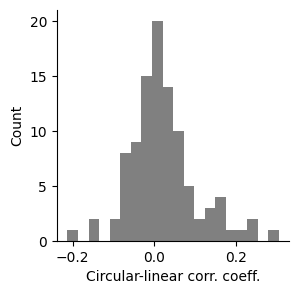

In [9]:
#plot histogram of circ_lin_corr
fig, ax = plt.subplots(1, 1, figsize=(3,3), dpi=100)
ax.hist(all_clcc, bins=20, color='grey')
ax.set_xlabel('Circular-linear corr. coeff.')
ax.set_ylabel('Count')
sns.despine()

# #check if the circular-linear correlation is significantly different from 0 
# #using wilcoxon signed-rank test
# from scipy.stats import wilcoxon
# w, p = wilcoxon(all_clcc)
# print('Wilcoxon signed-rank test: W = %.3f, p = %.3f' % (w, p))

In [13]:
# variable needed: cellindex, pc_activity, Position, goal_loc, theta_phase

#for cell index x vary from 0-49 and y vary from 0-49, plot the tuning map and the phase of spikes at each time step

all_clcc = []

for xi in range(0, num, 5):
    for yi in range(0, num, 5):
        cellindex = [xi, yi]

        fig = plt.figure(figsize=(8,3), dpi=100)
        gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])
        
        ####################################################################################################
        ax = plt.subplot(gs[0])
        #plot the tuning map
        tuningMap = get_tuningMap(pc_activity, 
                                    Position, 
                                    cellindex_x=cellindex[0],
                                    cellindex_y=cellindex[1],
                                    shift = 0,
                                    filter=True,
                                    samples_per_sec=1000,
                                    dim=num)
        ax.imshow(tuningMap, cmap='Blues', origin='lower')

        #mark the goal location
        ax.scatter(goal_loc[0]*num, goal_loc[1]*num, color='Orange', marker='*', s=100)

        ax.axis('off')


        ####################################################################################################
        #Phase against distance to goal
        ax = plt.subplot(gs[1])
        
        Dist2G = []
        SpikePhase = []
        RelativeDirection = []

        r = pc_activity[:, cellindex[0], cellindex[1]] * 1000 #ms to s

        for i in range(len(Position)):
            #get the distance to goal_loc
            dist_i = np.linalg.norm(Position[i] - goal_loc)
            dist_i = np.where(dist_i > 0.5, 1.0 - dist_i, dist_i)
  
            #get the vec pointing from Position to goal_loc
            vec = goal_loc - Position[i]
            #get the angle between vec and moving direction
            angle = np.arctan2(vec[1], vec[0]) - np.arctan2(Vel[i, 1], Vel[i, 0])
            angle = np.degrees(angle) % 360
            RelativeDirection.append(angle)
            
            #get the phase at current time step i
            phase_i = theta_phase[i]*np.pi*2
            
            spikes = np.random.poisson(r[i]*dt*10)
            if spikes > 0:
                #save dist_i and phase_i
                Dist2G.append(dist_i)
                SpikePhase.append(phase_i)
            

        Dist2G = np.asarray(Dist2G)
        SpikePhase = np.asarray(SpikePhase)

        ax.scatter(Dist2G, SpikePhase, s=3, color='black', alpha=0.3)

        ax.scatter(Dist2G, SpikePhase+2*np.pi, s=3, color='black', alpha=0.3)

        circ_lin_corr, pval, slope, phi0, RR = cl_corr(Dist2G, SpikePhase, min_slope=-2, max_slope=2, bootstrap_iter=3000, return_pval=True)
        all_clcc.append(circ_lin_corr)
        if True:
            # Plot the circular-linear regression
            x = np.linspace(-np.pi, np.pi, 100)
            y = 2 * np.pi * slope * x + phi0
            ax.plot(x, y, color='red', linewidth=1)
            #add intercepr of 2*pi, and plot the line again
            y = 2 * np.pi * slope * x + phi0 + 2 * np.pi
            ax.plot(x, y, color='red', linewidth=1)
            #add intercepr of 4*pi, and plot the line again
            y = 2 * np.pi * slope * x + phi0 + 4 * np.pi
            ax.plot(x, y, color='red', linewidth=1)
            #substrac intercepr of 2*pi, and plot the line again
            y = 2 * np.pi * slope * x + phi0 - 2 * np.pi
            ax.plot(x, y, color='red', linewidth=1) 

        # ax[0].set_xlabel('Head direction')
        ax.set_xlabel('Dist2Goal', fontsize=10)
        ax.set_ylabel('Theta phase', fontsize=10)
        #activity colorbar
        ax.set_xlim(0, 0.5)
        ax.set_xticks([0, 0.5])
        ax.set_ylim(0, 4*np.pi)
        ax.set_yticks([0, 2*np.pi, 4*np.pi])
        ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])   

        sns.despine()
        
        ####################################################################################################
        #ConSink
        ax = plt.subplot(gs[2], projection='polar')
        #r is the rate of the cell at each time, RelativeDirection is the angle between moving direction and the vector from Position to goal_loc at each time
        #Count the histogram of RelativeDirection, and weight the count with r
        # Define the bin edges from 0 to 360 degrees, creating 24 bins
        num_bins = 24
        bin_edges = np.linspace(0, 360, num_bins + 1)
        weighted_sum_r = np.zeros(num_bins)  # Array to store weighted sums

        # Calculate the weighted sum of firing rates for each directional bin
        for i in range(num_bins):
            # Find the time bins where RelativeDirection falls within the current bin
            in_bin = (RelativeDirection >= bin_edges[i]) & (RelativeDirection < bin_edges[i + 1])
            weighted_sum_r[i] = np.sum(r[in_bin])

        # Convert directions to radians for polar plot
        angles = np.deg2rad(np.linspace(0, 360, num_bins, endpoint=False))
        ax.bar(angles, weighted_sum_r, width=2 * np.pi / num_bins, align='center', edgecolor='black', color='lightgrey')    
        ax.set_yticks([])
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)

        plt.tight_layout()
        
        plt.savefig('./figures/phasevsgoaldist/Cell_'+str(cellindex[0])+'_'+str(cellindex[1])+'.png', dpi=300)
        
        plt.close()